Comparison of training both algorithms

[SAC + HER] Found evaluations.npz
[TQC + HER] Found evaluations.npz


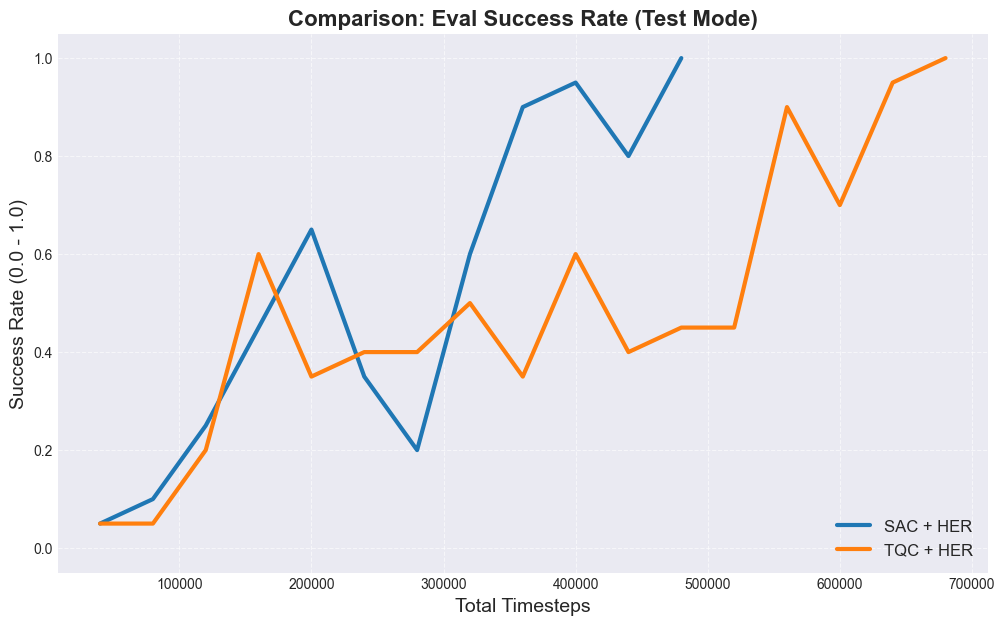

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# --- CONFIGURATION ---
# Update these paths to point to your log folders
log_dirs = {
    "SAC + HER": "logs/fetch_pick_place_her_sac", 
    "TQC + HER": "logs/fetch_pick_place_her_tqc"
}

# Settings from your training script (CRITICAL for aligning x-axis)
EVAL_FREQ = 2500       # How often you ran eval (e.g. every 2500 steps)
N_EVAL_EPISODES = 20   # How many episodes per eval (e.g. 20)

def load_eval_data(path, label):
    """
    Tries to load evaluation data.
    Priority 1: evaluations.npz (Generated by EvalCallback - Most Accurate)
    Priority 2: eval_monitor.csv (generated by Monitor wrapper - Needs x-axis reconstruction)
    """
    
    # 1. Try loading .npz (Best Data)
    npz_path = os.path.join(path, "evaluations.npz")
    if os.path.exists(npz_path):
        print(f"[{label}] Found evaluations.npz")
        data = np.load(npz_path)
        # data['timesteps'] is the x-axis, data['results'] is (n_evals, n_episodes)
        timesteps = data['timesteps']
        # Calculate success rate: mean of (reward > -50) for each eval batch
        # In Fetch, success is usually binary, but let's infer from reward if 'successes' array absent
        if 'results' in data:
            # Assume reward > -50 is success (Env specific)
            success_rates = np.mean(data['results'] > -50.0, axis=1)
        return timesteps, success_rates

    # 2. Fallback to eval_monitor.csv
    csv_path = os.path.join(path, "eval_monitor.csv") # filename might vary
    
    # sometimes it's named 'eval.csv' or just 'monitor.csv' inside an eval subfolder
    if not os.path.exists(csv_path):
        # check if there is an 'eval' folder?
        # Standard EvalCallback with log_path='logs/' usually saves npz.
        # If standard Monitor on eval_env was used:
        print(f"[{label}] Warning: evaluations.npz not found. Trying CSV...")
        
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, skiprows=1)
        # Reconstruct X-Axis based on row count
        # Each row is 1 episode. Every 20 rows = 1 Eval phase = 2500 timesteps.
        
        # We calculate the mean success rate over chunks of N_EVAL_EPISODES
        df['is_success'] = (df['r'] > -50.0).astype(int)
        
        # Group by eval batch
        n_rows = len(df)
        n_batches = n_rows // N_EVAL_EPISODES
        
        # Truncate to full batches
        df = df.iloc[:n_batches * N_EVAL_EPISODES]
        
        # Reshape to (n_batches, n_eval_episodes)
        success_matrix = df['is_success'].values.reshape(n_batches, N_EVAL_EPISODES)
        success_rates = np.mean(success_matrix, axis=1)
        
        # Create timesteps: 2500, 5000, 7500...
        timesteps = np.arange(1, n_batches + 1) * EVAL_FREQ
        
        return timesteps, success_rates

    print(f"[{label}] ❌ No evaluation data found.")
    return None, None

# --- PLOTTING ---
plt.figure(figsize=(12, 7))
plt.style.use('seaborn-v0_8-darkgrid')

for label, folder in log_dirs.items():
    x, y = load_eval_data(folder, label)
    
    if x is not None:
        plt.plot(x, y, linewidth=3, label=label)

plt.title("Comparison: Eval Success Rate (Test Mode)", fontsize=16, fontweight='bold')
plt.xlabel("Total Timesteps", fontsize=14)
plt.ylabel("Success Rate (0.0 - 1.0)", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.legend(fontsize=12, loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()